In [19]:
#carregando bibliotecas
library(psych)
library(reshape)
library(dplyr)
library(RColorBrewer)
library(gridExtra)
#library(ggplot2)
source("https://raw.githubusercontent.com/eogasawara/mylibrary/master/myGraphic.R")
source("https://raw.githubusercontent.com/eogasawara/mylibrary/master/myClustering.R")

#carregando dados
dados <-read.csv("C:/Users/Flávio/Desktop/Mestrado/Projeto (Using provenance to evaluate learning in educational games)/event.csv", header = TRUE, sep = ",")
head(dados)
nrow(dados)
ncol(dados)

id,session,type,agent,time,attr1,attr2,attr3
21898,194,plantar,grama,3,252,225,325
21899,194,plantar,grama,5,254,275,327
21900,194,plantar,grama,7,256,325,326
21901,194,desenvolvimento,grama,10,257,225,325
21902,194,plantar,grama,9,258,375,326
21903,194,desenvolvimento,grama,12,259,275,327


[1] 315401

[1] 8

In [20]:
dados$id <- NULL #removendo a coluna id

summary(dados)

#arrumando atributos categóricos
cols = c("type", "agent")
fac.dados = dados
fac.dados[cols] = lapply(dados[cols], factor)
summary(fac.dados)


    session                        type               agent       
 Min.   :194   ColisÃ£o sem resultado:213491   tomate    : 33447  
 1st Qu.:276   plantar               : 19487   besouro   : 30828  
 Median :290   desenvolvimento       : 18330   pulgao    : 29153  
 Mean   :302   Novo inseto           : 17707   cigarrinha: 23419  
 3rd Qu.:330   colher                : 16785   joaninha  : 16770  
 Max.   :444   Predacao              : 10280   grilo     : 15633  
               (Other)               : 19321   (Other)   :166151  
      time          attr1          attr2          attr3          
 Min.   :   1   Min.   :   0   Min.   :  -1   Min.   :-24999623  
 1st Qu.: 332   1st Qu.: 575   1st Qu.: 275   1st Qu.:      175  
 Median : 754   Median :1134   Median : 525   Median :      326  
 Mean   :1017   Mean   :1857   Mean   : 668   Mean   :  1384749  
 3rd Qu.:1739   3rd Qu.:2503   3rd Qu.: 754   3rd Qu.:  2070287  
 Max.   :2759   Max.   :7152   Max.   :7150   Max.   :  8300311  
  

    session                        type               agent       
 Min.   :194   ColisÃ£o sem resultado:213491   tomate    : 33447  
 1st Qu.:276   plantar               : 19487   besouro   : 30828  
 Median :290   desenvolvimento       : 18330   pulgao    : 29153  
 Mean   :302   Novo inseto           : 17707   cigarrinha: 23419  
 3rd Qu.:330   colher                : 16785   joaninha  : 16770  
 Max.   :444   Predacao              : 10280   grilo     : 15633  
               (Other)               : 19321   (Other)   :166151  
      time          attr1          attr2          attr3          
 Min.   :   1   Min.   :   0   Min.   :  -1   Min.   :-24999623  
 1st Qu.: 332   1st Qu.: 575   1st Qu.: 275   1st Qu.:      175  
 Median : 754   Median :1134   Median : 525   Median :      326  
 Mean   :1017   Mean   :1857   Mean   : 668   Mean   :  1384749  
 3rd Qu.:1739   3rd Qu.:2503   3rd Qu.: 754   3rd Qu.:  2070287  
 Max.   :2759   Max.   :7152   Max.   :7150   Max.   :  8300311  
  

In [21]:
#filtrando atributos não necessários no momento e tipos de eventos

#plantas
pop.plant = fac.dados[c(1,2,3,4)] %>% filter((type=="plantar"|type=="Predacao"|type=="colher") & (agent=="tomate"|agent=="milho"|agent=="couve"|agent=="grama"))
pop.plant = pop.plant[order(pop.plant$session, pop.plant$time),]

#pragas  
pop.plague = fac.dados[c(1,2,3,4)] %>% filter((type=="morte"|type=="Predacao"|type=="Novo inseto") & (agent=="grilo"|agent=="lagarta"|agent=="pulgao"|agent=="cigarrinha"))
pop.plague = pop.plague[order(pop.plague$session, pop.plague$time),]

#predadores
pop.predator = fac.dados[c(1,2,3,4)] %>% filter((type=="morte"|type=="Novo inseto"|type=="remover predador") & (agent=="besouro"|agent=="joaninha"))
pop.predator = pop.predator[order(pop.predator$session, pop.predator$time),]

gap = 10


In [22]:
#funcao cria dataframe
create_dataframe <- function(columm, gap) {
  df <- data.frame(matrix(ncol = columm, nrow = 0))
  n <- seq(1,columm,1)
  n[1] = 'session'
  for (i in 2:columm) {
    n[i] = paste('time',gap*(i-1))
  }
  names(df) = n
  return(df)
}

#funcao preenche valores NA
fill_na <- function(data, rows, datapop) {
  for (i in 1:rows) {
    start = FALSE
    end = datapop %>% filter(session == data[i,1])
    end <- ceiling(max(end$time)/gap+1)
    for (j in 2:length(data)){
      if (j <= end){
        if (is.na(data[i,j])){
          if (start){
            data[i,j] <- data[i, j-1]
          }else{
            data[i,j] <- 0
          }
        }else{
          start = TRUE
        }
      }else{
        data[i,j] <- 0
      }
    }
  }
  return(data)
}


In [23]:
#criando série de população de plantas
num_col = floor(max(pop.plant$time)/gap) + 2
series.pop.plant <- create_dataframe(num_col, gap)
actual_session = 0
line = 0
total_plant = 0
for(i in 1:length(pop.plant$session)){
    session <- pop.plant[i,]$session
    if(session != actual_session){
      line = line + 1
      actual_session <- session
      total_plant = 0
      series.pop.plant[line, 1] <- actual_session
    }
    if(pop.plant[i,]$type == "plantar"){
      total_plant = total_plant + 1
    }
    if(pop.plant[i,]$type == "Predacao" || pop.plant[i,]$type == "colher"){
      total_plant = total_plant - 1
    }
    col = floor(pop.plant[i,]$time/gap)+2
    if(total_plant < 0) total_plant = 0
    series.pop.plant[line, col] <- total_plant
}
series.pop.plant <- fill_na(series.pop.plant, nrow(series.pop.plant), pop.plant)

#criando série de população de pragas
num_col = floor(max(pop.plague$time)/gap) + 2
series.pop.plague <- create_dataframe(num_col, gap)
actual_session = 0
line = 0
total_plague = 0
for(i in 1:length(pop.plague$session)){
  session <- pop.plague[i,]$session
  if(session != actual_session){
    line = line + 1
    actual_session <- session
    total_plague = 0
    series.pop.plague[line, 1] <- actual_session
  }
  if(pop.plague[i,]$type == "Novo inseto"){
    total_plague = total_plague + 1
  }
  if(pop.plague[i,]$type == "Predacao" || pop.plant[i,]$type == "morte"){
    total_plague = total_plague - 1
  }
  col = floor(pop.plague[i,]$time/gap)+2
  series.pop.plague[line, col] <- total_plague
}
series.pop.plague <- fill_na(series.pop.plague, nrow(series.pop.plague), pop.plague)

#criando série de população de predadores
num_col = floor(max(pop.predator$time)/gap) + 2
series.pop.predator <- create_dataframe(num_col, gap)
actual_session = 0
line = 0
total_predator = 0
for(i in 1:length(pop.predator$session)){
  session <- pop.predator[i,]$session
  if(session != actual_session){
    line = line + 1
    actual_session <- session
    total_predator = 0
    series.pop.predator[line, 1] <- actual_session
  }
  if(pop.predator[i,]$type == "Novo inseto"){
    total_predator = total_predator + 1
  }
  if(pop.predator[i,]$type == "morte" || pop.predator[i,]$type == "remover predador"){
    total_predator = total_predator - 1
  }
  col = floor(pop.predator[i,]$time/gap)+2
  if(total_predator < 0) total_predator = 0
  series.pop.predator[line, col] <- total_predator
}
series.pop.predator <- fill_na(series.pop.predator, nrow(series.pop.predator), pop.predator)


In [24]:
###### REALIZANDO AGRUPAMENTO DAS SÉRIES ############

#função de agrupamento
test_clustering <- function(model, data, opt=FALSE) {
  print(class(model)[1])
  if (opt) 
    model <- optimize(model, data)    
  clu <- action(model, data)
  print(table(clu))
  return(clu)
}


In [25]:
return_cluster_comb <- function(data_serie1, data_serie2, data_serie3, sessions, num_k, cols) {
  series1 <- data_serie1[,1:cols] %>% filter(session %in% sessions)
  series2 <- data_serie2[,1:cols] %>% filter(session %in% sessions)
  series3 <- data_serie3[,1:cols] %>% filter(session %in% sessions)
  series.pop.comb <- merge(series1, series2, by.x = "session", by.y = "session")
  series.pop.comb <- merge(series.pop.comb, series3, by.x = "session", by.y = "session")
  series.pop.comb$k <- test_clustering(cluster_kmeans(k=num_k), series.pop.comb[,2:length((series.pop.comb))])
  return(series.pop.comb)
}

In [26]:
sessions <- c(211,212,239,240,241,259,260,261,262,263,264,271,272,273,274,275,300,303,305,306,307,308,309,328,330,331,332,333,334,335,336,337,338,339,340,341,342,344
              ,345,350,351,352,356,357,373,374,375,381,382,383,384,385,402,403,407,414,416,429)


In [30]:
##Gráfico separado

#funcao line cluster comb plots separado
line_cluster_sep <- function(data_serie, gap, title1, title2, title3) {
  #separando as séries
  serie1 <- data_serie[,2:61]
  serie1$k <- data_serie$k
  serie2 <- data_serie[,62:121]
  serie2$k <- data_serie$k
  serie3 <- data_serie[,122:181]
  serie3$k <- data_serie$k
  
  #calculando as médias
  mean.serie1 <- as.data.frame(serie1 %>% group_by(k)%>% summarise(across(everything(), list(mean))))
  mean.serie2 <- as.data.frame(serie2 %>% group_by(k)%>% summarise(across(everything(), list(mean))))
  mean.serie3 <- as.data.frame(serie3 %>% group_by(k)%>% summarise(across(everything(), list(mean))))
  
  #data plot 1
  data_plot1 <- melt(mean.serie1, id.vars = c(1))
  data_plot1 <- data_plot1[order(data_plot1$k, data_plot1$variable),]
  #criando eixo x
  data_plot1$x <- seq(from = 10, to = 600, by = gap)
  
  #data plot 2
  data_plot2 <- melt(mean.serie2, id.vars = c(1))
  data_plot2 <- data_plot2[order(data_plot2$k, data_plot2$variable),]
  #criando eixo x
  data_plot2$x <- seq(from = 10, to = 600, by = gap)
  
  #data plot 3
  data_plot3 <- melt(mean.serie3, id.vars = c(1))
  data_plot3 <- data_plot3[order(data_plot3$k, data_plot3$variable),]
  #criando eixo x
  data_plot3$x <- seq(from = 10, to = 600, by = gap)
  
  #grafico
  p1 <- ggplot(data_plot1, aes(x=x, y=value, group=k)) +
    geom_hline(yintercept =  10, linetype="dashed", color = "grey80", size=.7) + 
    geom_hline(yintercept =  20, linetype="dashed", color = "grey80", size=.7) +
    geom_hline(yintercept =  30, linetype="dashed", color = "grey80", size=.7) + 
    geom_hline(yintercept =  40, linetype="dashed", color = "grey80", size=.7) +
    scale_color_brewer(palette="Dark2")+
    geom_line(aes(color=as.factor(k)), size = 1.25) +
    #ggtitle(title1)
    labs(title=title1,x ="Time", y = "Quantity", color = "K")+
    #scale_y_continuous(limits = c(0, 45), breaks = c(15,30), labels = c("20", "40")) +
    theme(panel.background = element_rect(fill = "white", colour = "grey50"),
        axis.line = element_line(size = 2, colour = "grey80"),
        axis.ticks.x=element_blank(),
        axis.ticks.y=element_blank(),
        axis.text=element_text(size=14),
        axis.title=element_text(size=14,face="bold"),
        legend.text = element_text(size=14))
        #legend.position = "bottom")
  
  p2 <- ggplot(data_plot2, aes(x=x, y=value, group=k)) +
    geom_hline(yintercept =  20, linetype="dashed", color = "grey80", size=.7) + 
    geom_hline(yintercept =  40, linetype="dashed", color = "grey80", size=.7) +
    geom_hline(yintercept =  60, linetype="dashed", color = "grey80", size=.7) + 
    geom_hline(yintercept =  80, linetype="dashed", color = "grey80", size=.7) +
    scale_color_brewer(palette="Dark2")+
    geom_line(aes(color=as.factor(k)), size = 1.25) +
    #ggtitle(title2)
    labs(title=title2,x ="Time", y = "Quantity", color = "K")+
    #scale_y_continuous(limits = c(0, 45), breaks = c(15,30), labels = c("20", "40")) +
    theme(panel.background = element_rect(fill = "white", colour = "grey50"),
          axis.line = element_line(size = 2, colour = "grey80"),
          axis.ticks.x=element_blank(),
          axis.ticks.y=element_blank(),
          axis.text=element_text(size=14),
          axis.title=element_text(size=14,face="bold"),
          legend.text = element_text(size=14))
  
  
  p3 <- ggplot(data_plot3, aes(x=x, y=value, group=k)) +
    geom_hline(yintercept =  5, linetype="dashed", color = "grey80", size=.7) + 
    geom_hline(yintercept =  10, linetype="dashed", color = "grey80", size=.7) +
    scale_color_brewer(palette="Dark2")+
    geom_line(aes(color=as.factor(k)), size = 1.25) +
    #ggtitle(title3)
    labs(title=title3,x ="Time", y = "Quantity", color = "K")+
    #scale_y_continuous(limits = c(0, 45), breaks = c(15,30), labels = c("20", "40")) +
    theme(panel.background = element_rect(fill = "white", colour = "grey50"),
          axis.line = element_line(size = 2, colour = "grey80"),
          axis.ticks.x=element_blank(),
          axis.ticks.y=element_blank(),
          axis.text=element_text(size=14),
          axis.title=element_text(size=14,face="bold"),
          legend.text = element_text(size=14))
  
  g = grid.arrange(p1, p2, p3, nrow=3)
  return(g)
}

## sessoes do grupo 2 e 4
sessions <- c(211,212,239,240,241,259,260,261,262,263,264,271,272,273,274,275,300,303,305,306,307,308,309,328,330,331,332,333,334,335,336,337,338,339,340,341,342,344
              ,345,350,351,352,356,357,373,374,375,381,382,383,384,385,402,403,407,414,416,429)

set.seed(222)
data_serie <- return_cluster_comb(series.pop.plant, series.pop.plague, series.pop.predator, sessions, 4, 61)



[1] "cluster_kmeans"
clu
 1  2  3  4 
31 14  4  8 


`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)


TableGrob (3 x 1) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
3 3 (3-3,1-1) arrange gtable[layout]

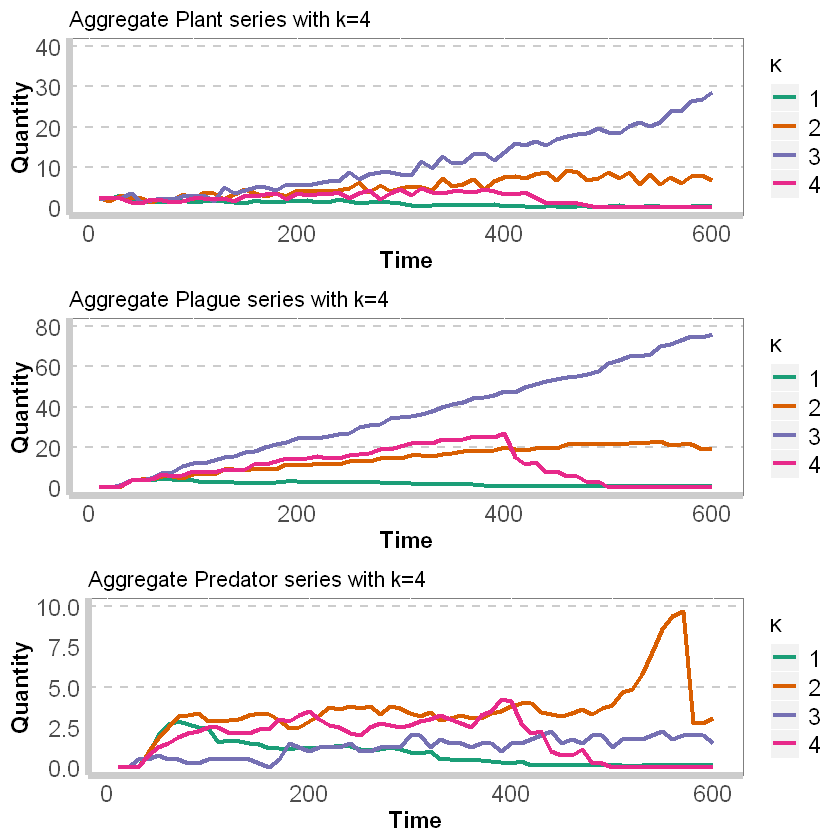

In [31]:
line_cluster_sep(data_serie, 10, "Aggregate Plant series with k=4", "Aggregate Plague series with k=4", "Aggregate Predator series with k=4")